In [1]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set()
%matplotlib inline

<h3> Introduction </h3>
From Quandl we can download the data for different bitcoin markets:
https://www.quandl.com/data/BCHAIN/MKPRU-Bitcoin-Market-Price-USD

In [2]:
df = quandl.get('BCHARTS/KRAKENUSD', returns="pandas")

inspecting the different datatypes in the dataframe

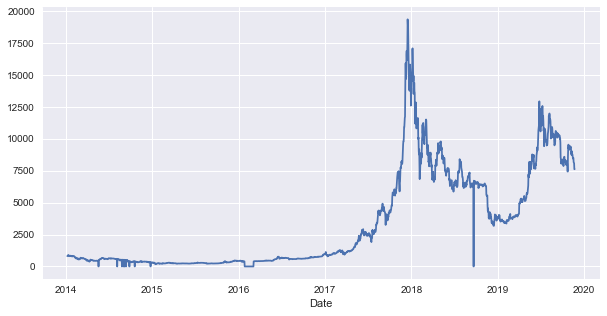

In [3]:
df['Close'].plot(figsize=(10,5));

There are a few notable down-spikes, particularly in late 2014 and early 2016. These spikes are specific to the Kraken dataset, and we obviously don't want them to be reflected in our overall pricing analysis.
<b>Let's remove the values where the Bitcoin is zero</b>

In [4]:
idx = df['Close']==0

In [5]:
print('There are ',sum(idx), ' such observations in the dataset')

There are  49  such observations in the dataset


In [6]:
df.drop(df.loc[idx].index,axis=0,inplace=True)

In [7]:
idx = df['Close']==0
print('Check: There are ',sum(idx), ' such observations in the dataset')

Check: There are  0  such observations in the dataset


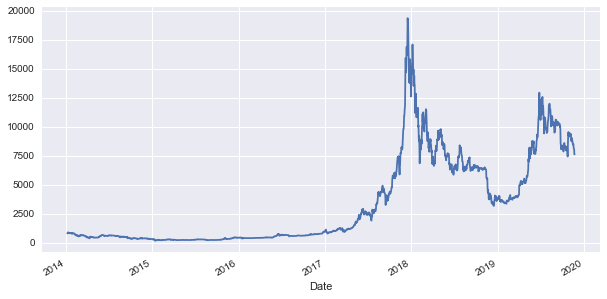

In [8]:
df['Close'].plot(figsize=(10,5));

<h3>Calculating the logreturns</h3>


In [9]:
df['logret'] = df['Close'].pct_change(periods=1).apply(lambda x : np.log(1+x))
df.dropna(how='any',inplace=True)


<h3> Kernel Density </h3>

In [10]:
data = np.array(df['logret']).reshape(-1,1)
param_grid = {'bandwidth': np.arange(0.001,0.05,0.001),
              'kernel':['gaussian','tophat']}
grid = GridSearchCV(KernelDensity(),param_grid)
grid.fit(data)

/Users/jandespiegeleer/.pyenv/versions/3.6.5/envs/seminar/lib/python3.6/site-packages/sklearn/model_selection/_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


GridSearchCV(cv=None, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049]), 'kernel': ['gaussian', 'tophat']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
bw = grid.best_estimator_.bandwidth
kernel = grid.best_estimator_.kernel
print('The best kernel is a '+ kernel + ' with a bandwith of ' + str(bw))

The best kernel is a gaussian with a bandwith of 0.013000000000000001


In [12]:
kde = KernelDensity(kernel='gaussian',bandwidth=bw)
kde.fit(data)


KernelDensity(algorithm='auto', atol=0, bandwidth=0.013000000000000001,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)

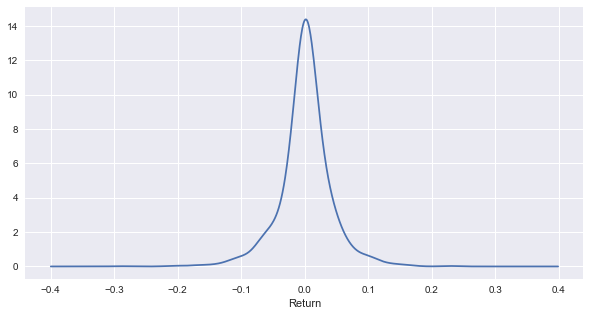

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(-0.4,0.4,0.001).reshape(-1,1),
        np.exp(kde.score_samples(np.arange(-0.4,0.4,0.001).reshape(-1,1))))
ax.set_xlabel('Return');

<h3> Is bitcoin following a normal distribution ? </h3>

In [14]:
from scipy import stats

(array([-7.32131713, -6.43453221, -5.9680638 , ...,  5.9680638 ,
         6.43453221,  7.32131713]),
 array([-0.29153141, -0.21049248, -0.20466784, ...,  0.17088507,
         0.22428302,  0.23588143]))

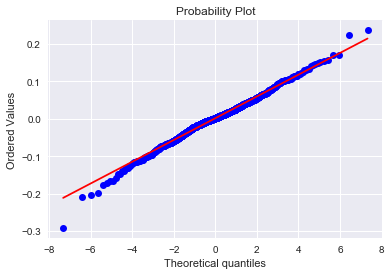

In [15]:
stats.probplot(np.array(data).reshape(-1,),plot=plt,dist='laplace',fit=False)